Here we will build a regression model to predict the missing Temperature values within the training and test datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from geopy import distance
import pickle
from utils_dump_load import load_from_pickle, dump_to_pickle

In [2]:
pd.set_option('display.max_columns', 40)

<h1> Loading the data

In [3]:
filepath_test = "data/Test.csv"
df_test = pd.read_csv(filepath_test, index_col="Order No")
df_test.shape

(7068, 24)

In [4]:
filepath_train = "data/Train.csv"
df_train = pd.read_csv(filepath_train, index_col="Order No")
df_train.shape

(21201, 28)

<h1> Creating the needed features

In [5]:
def get_hour(x):
    datetime_object = datetime.strptime(x, "%I:%M:%S %p")
    return datetime_object.hour

In [6]:
df_train["Pickup - Hour"] = df_train["Pickup - Time"].apply(lambda x: get_hour(x))
df_test["Pickup - Hour"] = df_test["Pickup - Time"].apply(lambda x: get_hour(x))

<h1> Feature selection

In [7]:
feature_selection = ["Pickup - Day of Month", "Pickup - Weekday (Mo = 1)", "Pickup - Hour" ]

In [8]:
df = df_train.dropna()

In [9]:
y = df["Temperature"]
X = df[feature_selection]

In [10]:
y.isna().sum()

0

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X__train, X__test, y__train, y__test = train_test_split(X, y, random_state=0, test_size=0.2)

In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X__train, y__train)
y_pred = lr.predict(X__test)

mean_squared_error(y__test, y_pred)

3.333019830584398

In [15]:
from lightgbm.sklearn import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(X__train, y__train)
y_pred = lgbm.predict(X__test)

mean_squared_error(y__test, y_pred)

1.0725759514217368

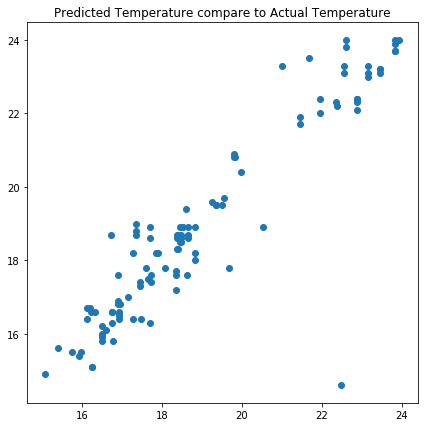

In [18]:
plt.figure(figsize=(7,7))
plt.scatter(y_pred, y__test)
plt.title("Predicted Temperature compare to Actual Temperature")
plt.show()

Let's choose the LGBM model  !!

<h1> Let's fit the LGBM regressor on all actual values

In [19]:
df_train.shape, df_test.shape

((21201, 29), (7068, 25))

In [20]:
y_train = df_train["Temperature"]
X_train = df_train[feature_selection]
X_train.shape

(21201, 3)

In [21]:
y_test = df_test["Temperature"]
X_test = df_test[feature_selection]
X_test.shape

(7068, 3)

In [22]:
y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

In [23]:
y.shape, X.shape

((28269,), (28269, 3))

In [24]:
y_known = y[y.isna()==False]
X_known = X[y.isna()==False]

y_unknown = y[y.isna()==True]
X_unknown = X[y.isna()==True]

X_known.shape, X_unknown.shape

((22466, 3), (5803, 3))

In [25]:
y_unknown.isna().sum()

5803

In [26]:
from lightgbm.sklearn import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(X_known, y_known)
y_pred = lgbm.predict(X_unknown)

In [27]:
y_test_unknow = lgbm.predict(X_test[y_test.isna()==True])
y_train_unknow = lgbm.predict(X_train[y_train.isna()==True])

In [29]:
y_train[y_train.isna()==True] = y_train_unknow
y_test[y_test.isna()==True] = y_test_unknow

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/zyncus/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
print(y_train.isna().sum())
print(y_test.isna().sum())

0
0


In [31]:
df_train["Temperature"] = y_train
df_test["Temperature"] = y_test

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21201 entries, Order_No_4211 to Order_No_9836
Data columns (total 29 columns):
User Id                                      21201 non-null object
Vehicle Type                                 21201 non-null object
Platform Type                                21201 non-null int64
Personal or Business                         21201 non-null object
Placement - Day of Month                     21201 non-null int64
Placement - Weekday (Mo = 1)                 21201 non-null int64
Placement - Time                             21201 non-null object
Confirmation - Day of Month                  21201 non-null int64
Confirmation - Weekday (Mo = 1)              21201 non-null int64
Confirmation - Time                          21201 non-null object
Arrival at Pickup - Day of Month             21201 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         21201 non-null int64
Arrival at Pickup - Time                     21201 non-null object
Pickup - Day

In [83]:
df_train.shape, df_test.shape

((21201, 29), (7068, 25))

<h1> Dumping dataframes train and test with filled Temperature feature

In [33]:
pickle_filename = "data/train_temp.pkl"
content = df_train
dump_to_pickle(content, pickle_filename)

In [34]:
pickle_filename = "data/test_temp.pkl"
content = df_test
dump_to_pickle(content, pickle_filename)